In [ ]:
# import zipfile
# with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
#     zip.ref.extractall('./')

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

In [2]:
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

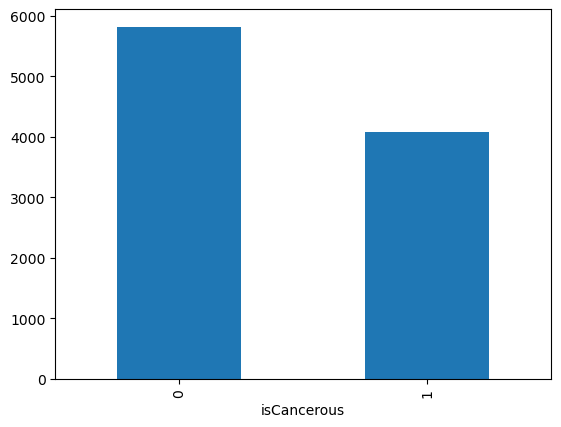

In [3]:
data['isCancerous'].value_counts().plot(kind='bar')

data.isnull().sum()

<Axes: xlabel='cellType'>

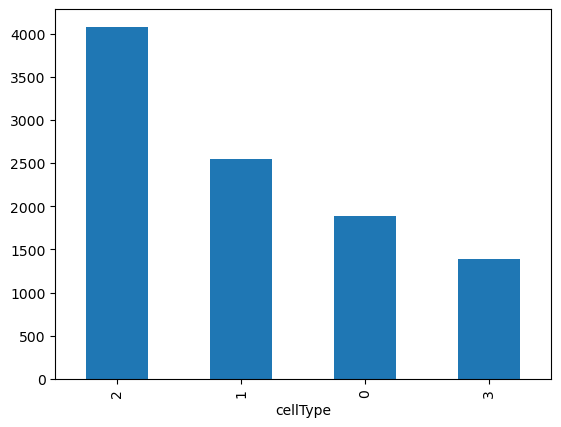

In [7]:
data['cellType'].value_counts().plot(kind='bar')

In [82]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.feature import hog
# from skimage import data, exposure
from skimage.io import imread
from skimage.color import rgba2rgb, rgb2gray

patient_dict = {}
for i in range (len(data['patientID'].unique())):
    patient_dict[i] = data[data['patientID'] == i]


<Figure size 2000x0 with 0 Axes>

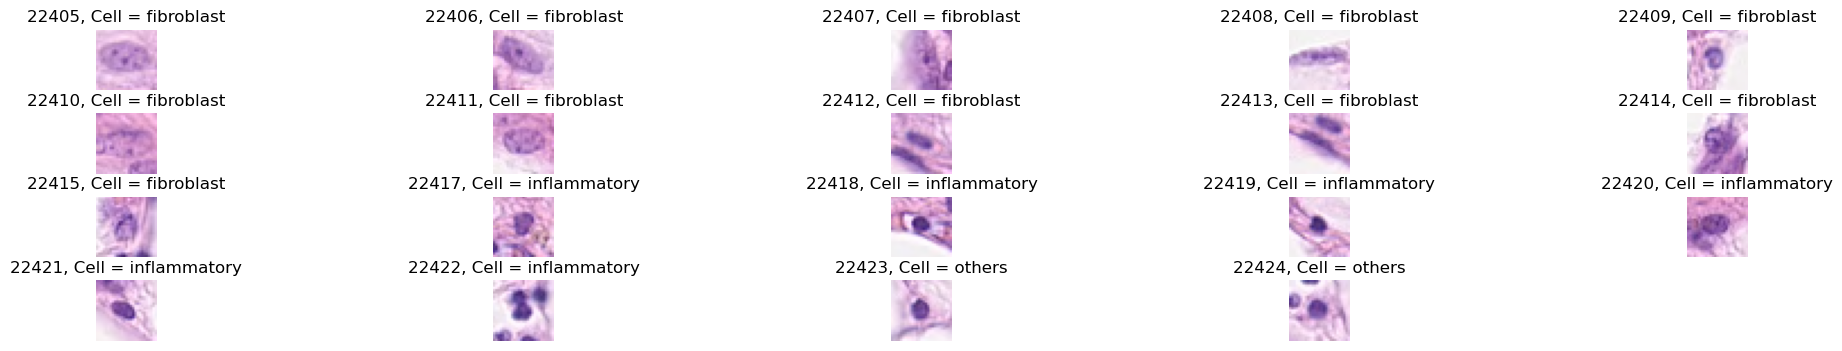

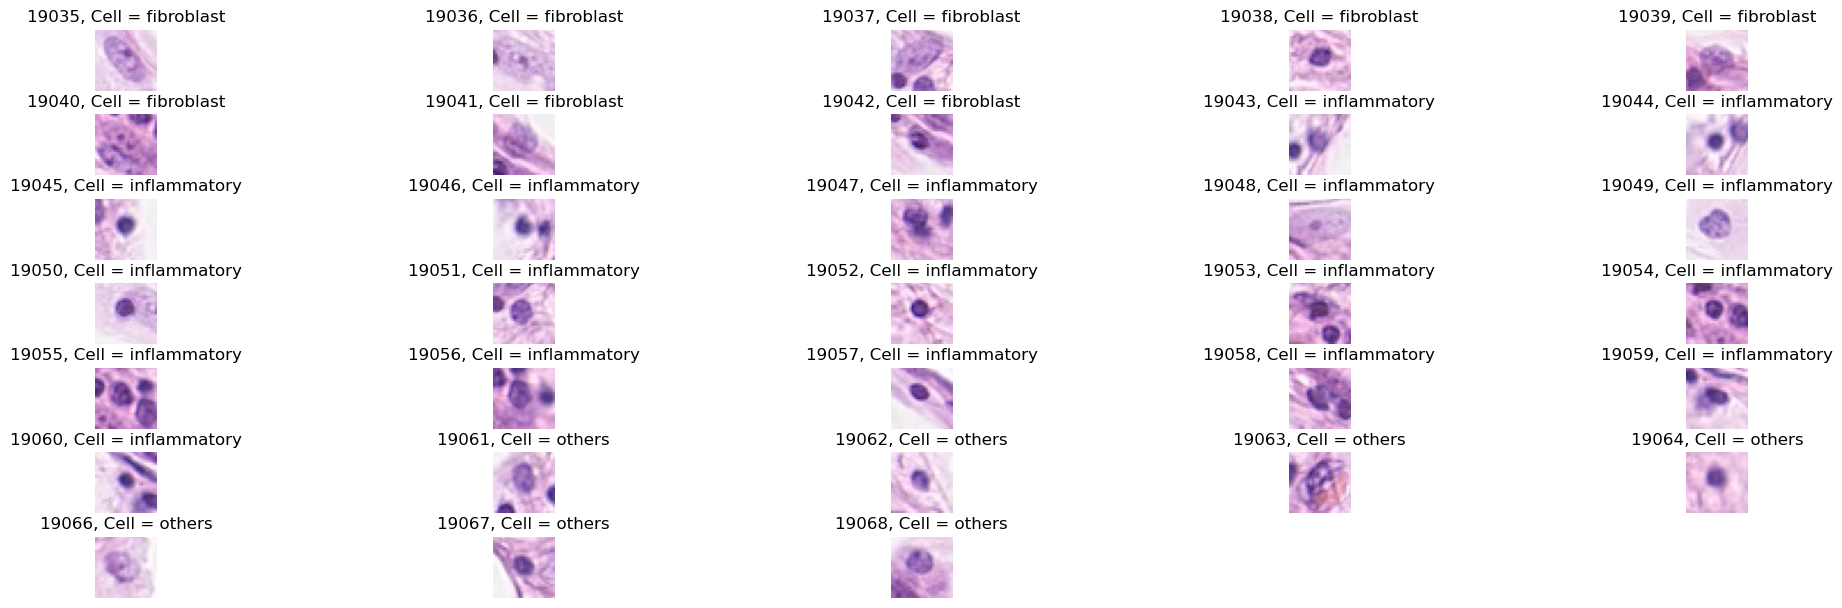

In [85]:


# len(patient_dict)
import math
for i in range(0, 3):
    patient = patient_dict[i]
    num = len(patient)
    col = 5
    row = math.ceil(num/col)
    plt.figure(figsize=(col * 4, row * 4))
    for j in range(0, len(patient)):
        # print(j)
        image_path = patient.iloc[j]['ImageName']
        # print(image_path)
        im = imread(f'./Image_classification_data/patch_images/{image_path}', as_gray=False, plugin=None)
        # print('yes')
        plt.subplot(num, col, j + 1)
        plt.title(f'{patient.iloc[j]['InstanceID']}, Cell = {patient.iloc[j]['cellTypeName']}')
        plt.imshow(im, cmap=plt.cm.gray)
        plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=0.2, w_pad=0.2)
    plt.show()

   

<Axes: xlabel='cellTypeName'>

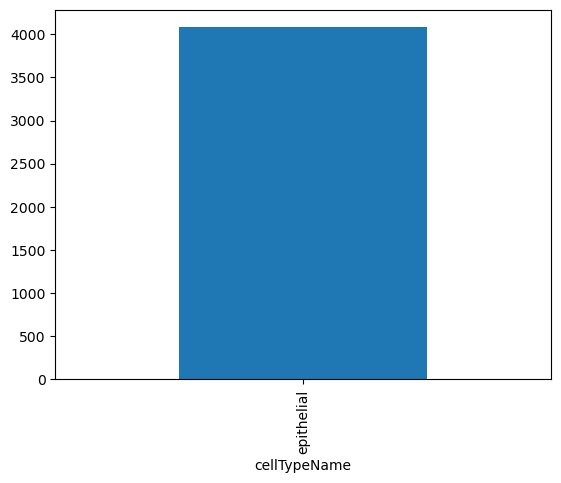

In [9]:
data[data['isCancerous'] == 1]['cellTypeName'].value_counts().plot(kind='bar')
